In [1]:
import karel_env.dataset_karel as dataset

In [2]:
dataset_train, _, _ = dataset.create_default_splits('datasets/karel_dataset/', num_k=10)
data_id = dataset_train.ids
obs = dataset_train.get_data(data_id[0])

/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:145: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  num_train = int(f['data_info']['num_train'].value)
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:146: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  num_test = int(f['data_info']['num_test'].value)
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:147: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  num_val = int(f['data_info']['num_val'].value)
[2021-12-20 17:33:17,250] Reading datasets/karel_dataset/data.hdf5 ...
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.dsl_type = self.data['data_info']['dsl_type'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:28: H5p

In [3]:
obs[3][:, :, :,:,:].shape

(5, 20, 8, 8, 16)

In [4]:
obs[1]

array([ 0,  1,  2,  6,  4,  4,  5,  6,  5, 38, 32, 41, 33, 34,  4, 35,  3,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)

In [5]:
from karel_env import karel_util

In [6]:
from PIL import Image
karel_util.state2symbol(dataset_train.get_data(data_id[1000])[3][4, 8, :,:,:])

########
#.#.##.#
#.##.oo#
#.#.o..#
#..o...#
#.#<oo.#
##o.#..#
########


In [7]:
karel_util.state2image(dataset_train.get_data(data_id[1000])[3][3, 5, :,:,:]).shape

(80, 80, 3)

In [8]:
dataset_train.get_data(data_id[1000])[1]

array([ 0,  1,  2,  4,  5,  8,  8, 49, 32, 41, 33, 47,  4,  8, 48,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int8)

/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  program_tokens = self.data[id]['program'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:50: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  demo_data = self.data[id]['s_h'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:51: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test_demo_data = self.data[id]['test_s_h'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:57: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  per_data = self.data[id]['per'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test_per_data = self.

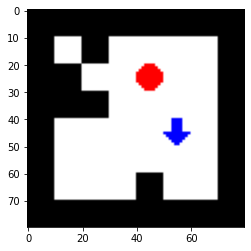

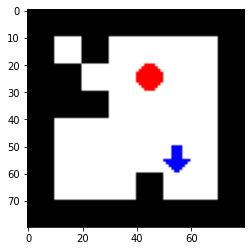

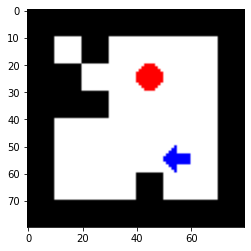

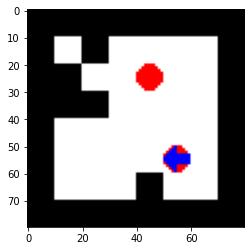

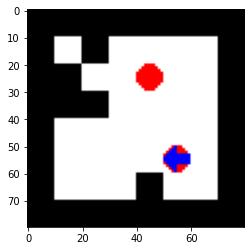

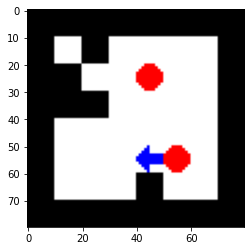

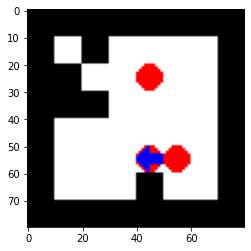

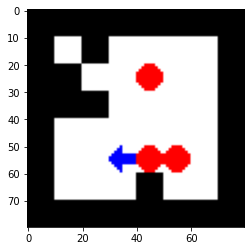

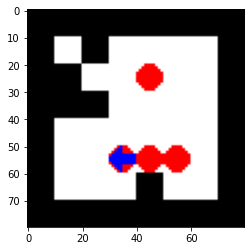

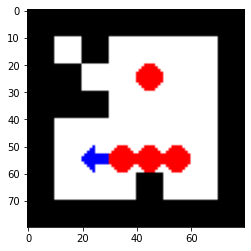

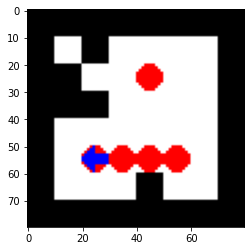

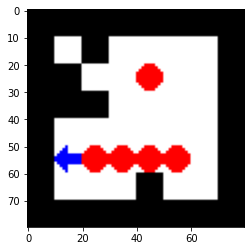

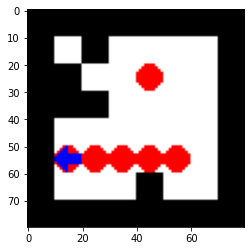

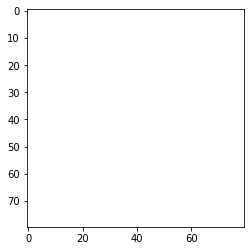

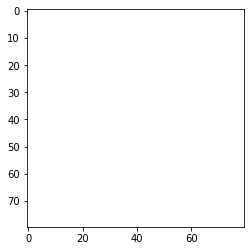

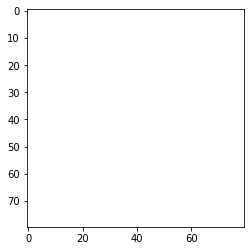

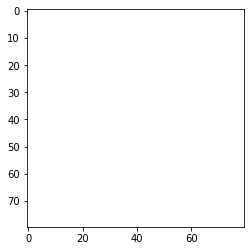

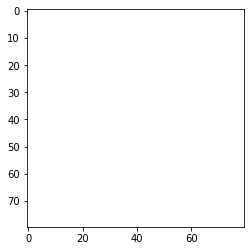

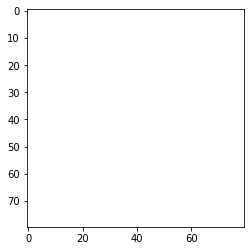

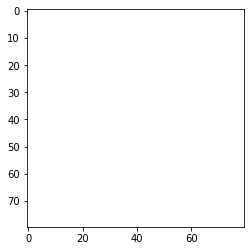

In [9]:
import matplotlib.pyplot as plt
for i in range(20):
    plt.imshow(karel_util.state2image(dataset_train.get_data(data_id[1000])[3][2, i, :,:,:]))
    plt.show()

In [10]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [11]:
import karel_env.dataset_karel as dataset
from torch.utils.data import Dataset

class KarelVideoDataset(Dataset):
    def __init__(self, dataset_path='datasets/karel_dataset/', num_k=10, 
                 train=False, test=False, val=False, 
                 transform=None, target_transform=None):
        check_arr = [train, test, val]
        if check_arr.count(True) == 0:
            raise RuntimeError('No Dataset type specified')
        
        if check_arr.count(True) > 1:
            raise RuntimeError('Multiple Dataset types specified')
        
        dataset_train, dataset_test, dataset_val \
            = dataset.create_default_splits(dataset_path, num_k=num_k)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.test = test
        self.val = val
        
        if self.train:
            self.data_ids = dataset_train.ids
            self.dataset = dataset_train
        elif self.test:
            self.data_ids = dataset_test.ids
            self.dataset = dataset_test
        else:
            self.data_ids = dataset_val.ids
            self.dataset = dataset_val

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        data = self.dataset.get_data(data_id)
        observation = data[2]
        padded_program_tokens = data[1]
        if self.transform:
            observation = self.transform(observation)
        if self.target_transform:
            padded_program_tokens = self.target_transform(padded_program_tokens)
        """ 
        get_data(id) returns:
            program, padded_program_tokens, demo[:self.num_k], test_demo, \
            action_history[:self.num_k], padded_action_history_tokens[:self.num_k], \
            test_action_history, padded_test_action_history_tokens, \
            program_length, demo_length[:self.num_k], test_demo_length, \
            pad_per_data[:self.num_k], pad_test_per_data
        """
        return observation, padded_program_tokens

In [12]:
from torchvision import transforms

class KarelVideoDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    # OPTIONAL, called for every GPU/machine (assigning state is OK)
    def setup(self, stage = None):
        # transforms
        transform = transforms.Compose([transforms.ToTensor()])
        # split dataset
        if stage in (None, "fit"):
            # in the paper they use the test for training and not the val
            # acutally the terms are somehow mixed 
            self.karel_train = KarelVideoDataset(train=True, transform=transform)
            self.karel_val =  KarelVideoDataset(test=True, transform=transform)
        if stage == "test":
            self.karel_test = KarelVideoDataset(val=True, transform=transform)
        if stage == "predict":
            self.karel_predict = KarelVideoDataset(val=True, transform=transform)

    # return the dataloader for each split
    def train_dataloader(self):
        return DataLoader(self.karel_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.karel_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.karel_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.karel_predict, batch_size=self.batch_size)

In [13]:
class ProgramSynthesisTransformer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [14]:
# init model
model = ProgramSynthesisTransformer()
train_loader = KarelVideoDataModule()
# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
trainer = pl.Trainer(gpus=1)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/eberhardinger/anaconda3/envs/python3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:145: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  num_train = int(f['data_info']['num_train'].value)
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:146: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  num_test = int(f['data_info']['num_test'].value)
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:147: H5pyDeprecationWarning: dataset.value has been deprecated. Use 

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s] 

/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  program_tokens = self.data[id]['program'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:50: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  demo_data = self.data[id]['s_h'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:51: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test_demo_data = self.data[id]['test_s_h'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:57: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  per_data = self.data[id]['per'].value
/home/eberhardinger/workspaces/demo2program/karel_env/dataset_karel.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  test_per_data = self.

ValueError: pic should be 2/3 dimensional. Got 5 dimensions.

In [19]:
from karel_env.dsl import get_KarelDSL
get_KarelDSL(dsl_type=dataset_train.dsl_type.decode(), seed=123)

In [18]:
dataset_train.dsl_type.decode()

'prob'